In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep


Using TensorFlow backend.


In [2]:
#Tissue types to compile data for

tissue_types = [
    'Adipose_Subcutaneous',
    'Adipose_Visceral_Omentum',
    'Adrenal_Gland',
    'Artery_Aorta',
    'Artery_Coronary',
    'Artery_Tibial',
    'Brain_Amygdala',
    'Brain_Anterior_cingulate_cortex_BA24',
    'Brain_Caudate_basal_ganglia',
    'Brain_Cerebellar_Hemisphere',
    #'Brain_Cerebellum',
    'Brain_Cortex',
    'Brain_Frontal_Cortex_BA9',
    'Brain_Hippocampus',
    'Brain_Hypothalamus',
    'Brain_Nucleus_accumbens_basal_ganglia',
    'Brain_Putamen_basal_ganglia',
    'Brain_Spinal_cord_cervical_c-1',
    'Breast_Mammary_Tissue',
    'Cells_EBV-transformed_lymphocytes',
    'Cells_Transformed_fibroblasts',
    'Colon_Sigmoid',
    'Colon_Transverse',
    'Esophagus_Gastroesophageal_Junction',
    'Esophagus_Mucosa',
    'Esophagus_Muscularis',
    #'Heart_Atrial_Appendage',
    'Heart_Left_Ventricle',
    'Liver',
    'Lung',
    'Muscle_Skeletal',
    'Nerve_Tibial',
    'Ovary',
    'Pancreas',
    'Pituitary',
    'Prostate',
    'Skin_Not_Sun_Exposed_Suprapubic',
    'Skin_Sun_Exposed_Lower_leg',
    'Small_Intestine_Terminal_Ileum',
    'Spleen',
    'Stomach',
    'Testis',
    'Thyroid',
    'Uterus',
    'Vagina',
    'Whole_Blood'
]


In [3]:

version_suffix = '_lead_deeppasta'


In [6]:

tissue_type_map = {
    'Adipose_Subcutaneous' : 'mean',
    'Adipose_Visceral_Omentum' : 'mean',
    'Adrenal_Gland' : 'mean',
    'Artery_Aorta' : 'mean',
    'Artery_Coronary' : 'mean',
    'Artery_Tibial' : 'mean',
    'Brain_Amygdala' : 'brain',
    'Brain_Anterior_cingulate_cortex_BA24' : 'brain',
    'Brain_Caudate_basal_ganglia' : 'brain',
    'Brain_Cerebellar_Hemisphere' : 'brain',
    #'Brain_Cerebellum',
    'Brain_Cortex' : 'brain',
    'Brain_Frontal_Cortex_BA9' : 'brain',
    'Brain_Hippocampus' : 'brain',
    'Brain_Hypothalamus' : 'brain',
    'Brain_Nucleus_accumbens_basal_ganglia' : 'brain',
    'Brain_Putamen_basal_ganglia' : 'brain',
    'Brain_Spinal_cord_cervical_c-1' : 'brain',
    'Breast_Mammary_Tissue' : 'mean',
    'Cells_EBV-transformed_lymphocytes' : 'mean',
    'Cells_Transformed_fibroblasts' : 'mean',
    'Colon_Sigmoid' : 'mean',
    'Colon_Transverse' : 'mean',
    'Esophagus_Gastroesophageal_Junction' : 'mean',
    'Esophagus_Mucosa' : 'mean',
    'Esophagus_Muscularis' : 'mean',
    #'Heart_Atrial_Appendage',
    'Heart_Left_Ventricle' : 'mean',
    'Liver' : 'liver',
    'Lung' : 'mean',
    'Muscle_Skeletal' : 'muscle',
    'Nerve_Tibial' : 'mean',
    'Ovary' : 'mean',
    'Pancreas' : 'mean',
    'Pituitary' : 'mean',
    'Prostate' : 'mean',
    'Skin_Not_Sun_Exposed_Suprapubic' : 'mean',
    'Skin_Sun_Exposed_Lower_leg' : 'mean',
    'Small_Intestine_Terminal_Ileum' : 'mean',
    'Spleen' : 'mean',
    'Stomach' : 'mean',
    'Testis' : 'testis',
    'Thyroid' : 'mean',
    'Uterus' : 'mean',
    'Vagina' : 'mean',
    'Whole_Blood' : 'mean'
}


median spearman r = 0.33, n = 1463.0
median p-value = 0.082097, n = 1463.0
median dir AP = 0.68
median sig AP = 0.63


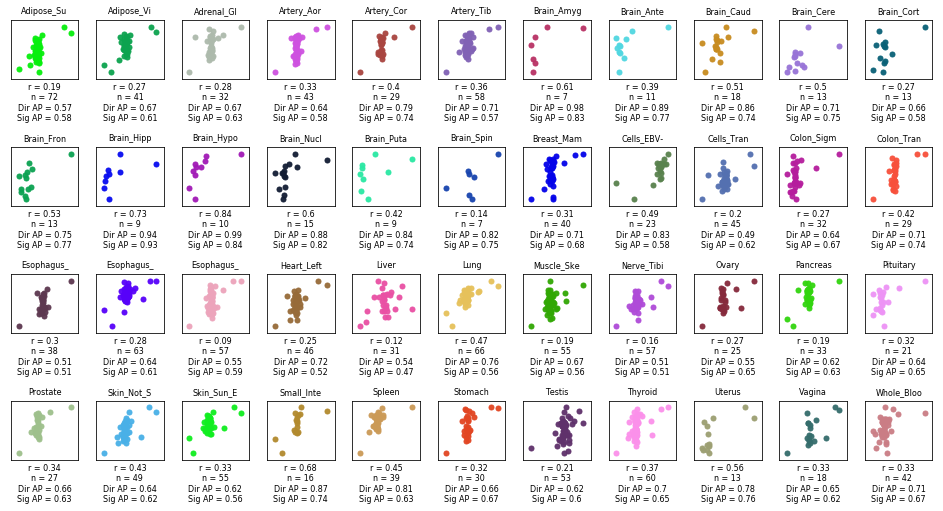

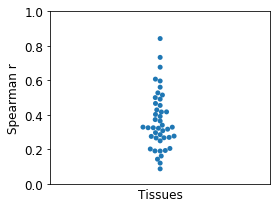

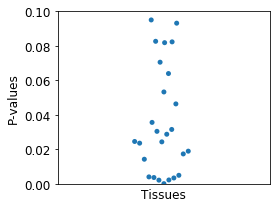

In [7]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import average_precision_score
import random

save_figs = False

n_rows = 4
n_cols = 11

f, axs = plt.subplots(n_rows, n_cols, figsize=(1.2 * n_cols, 1.8 * n_rows))

spearman_r_vals = []
spearman_p_vals = []
ns = []

dir_ap_vals = []
sig_ap_vals = []

total_n = 0.

blacklist_ids = [
    'chr5_76728085_C_T'
]

for i, tissue_type in enumerate(tissue_types) :
    
    snp_pred_df = pd.read_csv("predictions/apa_gtex_data/polyadb_merged_lead_SNPs_deeppasta.csv", sep='\t')
    snp_pred_df = snp_pred_df.query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)
    
    snp_pred_df['cis_snp'] = snp_pred_df['snp_distance'].apply(lambda x: 1. if x < 150 else -1.)
    
    snp_pred_df['snp_pos'] = snp_pred_df['rel_snp_pos'] - 105
    
    snp_pred_df['delta_isoform_logodds'] = snp_pred_df['delta_isoform_logodds_' + tissue_type_map[tissue_type]]
    
    #PDUI
    snp_pred_df['mean_PDUI_pred_var'] = 1. - 1. / (1. + (snp_pred_df['mean_PDUI'] / (1. - snp_pred_df['mean_PDUI'])) * np.exp(snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']))
    snp_pred_df['effect_size_pred'] = snp_pred_df['mean_PDUI_pred_var'] - snp_pred_df['mean_PDUI']

    snp_pred_df['delta_isoform_logodds'] = snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']

    snp_pred_df = snp_pred_df.drop(columns=['mean_PDUI_pred_var'])
    
    lead_snp_pred_df = snp_pred_df.copy().reset_index(drop=True)
    
    lead_snp_pred_df['cut_to_snp'] = np.abs(lead_snp_pred_df['snp_pos'] - 100)
    lead_snp_pred_df = lead_snp_pred_df.sort_values(by='cut_to_snp', ascending=True).drop_duplicates(subset=['snp_id'], keep='first')
    
    lead_snp_pred_df = lead_snp_pred_df.sort_values(by='snp_id').copy().reset_index(drop=True)
    
    lead_snp_pred_df_backup = lead_snp_pred_df
    
    filtered_df = lead_snp_pred_df.query("snp_pos >= 20 and snp_pos < 126 and pas != -1")# and site_type == '3_most_exon'
    
    filtered_df = filtered_df.loc[~filtered_df['snp_id'].isin(blacklist_ids)]
    
    row = i // n_cols
    col = i % n_cols
    
    y_pred = np.ravel(np.array(filtered_df['effect_size_pred'].values))
    y_true = np.ravel(np.array(filtered_df['effect_size'].values))

    spearman_r_val, spearman_p_val = spearmanr(y_pred, y_true)
    
    y_labels = np.array(filtered_df['effect_size'].apply(lambda x: 0 if x < 0. else 1).values)
    y_score = np.array(filtered_df['effect_size_pred'].values)
    
    dir_average_precision = average_precision_score(y_labels, y_score)

    q_val = np.quantile(np.abs(filtered_df['effect_size'].values), q=0.5)

    y_labels = np.array(filtered_df['effect_size'].apply(lambda x: 0 if np.abs(x) < q_val else 1).values)
    y_score = np.array(filtered_df['effect_size_pred'].values)

    sig_average_precision = average_precision_score(y_labels, y_score)

    if i < 49 :
        
        rgb = (random.random(), random.random(), random.random())
        
        axs[row, col].scatter(y_pred, y_true, alpha=0.95, s=25, color=rgb)
        axs[row, col].set_title(tissue_type[:10], fontsize=8)
        axs[row, col].set_xlabel("r = " + str(round(spearman_r_val, 2)) + "\nn = " + str(int(len(filtered_df))) + "\nDir AP = " + str(round(dir_average_precision, 2)) + "\nSig AP = " + str(round(sig_average_precision, 2)), fontsize=8)
        
        x_width = np.max(y_pred) - np.min(y_pred)
        y_width = np.max(y_true) - np.min(y_true)
        
        if x_width > 0 and y_width > 0 :
            axs[row, col].set_xlim(
                np.min(y_pred) - 0.15 * x_width,
                np.max(y_pred) + 0.15 * x_width
            )

            axs[row, col].set_ylim(
                np.min(y_true) - 0.15 * y_width,
                np.max(y_true) + 0.15 * y_width
            )
    
    if not np.isnan(spearman_r_val) :
        spearman_r_vals.append(spearman_r_val)
        spearman_p_vals.append(spearman_p_val)
        ns.append(int(len(filtered_df)))
        
        dir_ap_vals.append(dir_average_precision)
        sig_ap_vals.append(sig_average_precision)
    
    total_n += y_pred.shape[0]

for row in range(n_rows) :
    
    for col in range(n_cols) :

        axs[row, col].set_xticks([], [])
        axs[row, col].set_yticks([], [])

plt.tight_layout()

print('median spearman r = ' + str(round(np.median(spearman_r_vals), 2)) + ', n = ' + str(total_n))
print('median p-value = ' + str(round(np.median(spearman_p_vals), 6)) + ', n = ' + str(total_n))

print('median dir AP = ' + str(round(np.median(dir_ap_vals), 2)))
print('median sig AP = ' + str(round(np.median(sig_ap_vals), 2)))

if save_figs :
    plt.savefig('gtex_apaqtl_pred_deeppasta_multi' + version_suffix + '.png', dpi=150, transparent=True)
    plt.savefig('gtex_apaqtl_pred_deeppasta_multi' + version_suffix + '.eps')

plt.show()

import seaborn as sns

f = plt.figure(figsize=(4, 3))

ax = sns.swarmplot(data=[np.array(spearman_r_vals)])

plt.xticks([], [], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0., 1.0)

plt.xlabel("Tissues", fontsize=12)
plt.ylabel("Spearman r", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_deeppasta_r_value_swarm" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_deeppasta_r_value_swarm" + version_suffix + ".eps")

plt.show()

import seaborn as sns

f = plt.figure(figsize=(4, 3))

ax = sns.swarmplot(data=[np.array(spearman_p_vals)])

plt.xticks([], [], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0., 0.1)

plt.xlabel("Tissues", fontsize=12)
plt.ylabel("P-values", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_deeppasta_p_value_swarm" + version_suffix + ".png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_deeppasta_p_value_swarm" + version_suffix + ".eps")

plt.show()


In [8]:
#Save r-values and p-values

np.save('gtex_tissue_spearman_r_vals_deeppasta', np.array(spearman_r_vals))
np.save('gtex_tissue_spearman_p_vals_deeppasta', np.array(spearman_p_vals))
np.save('gtex_tissue_ns_deeppasta', np.array(ns))


Direction AP = 0.613
Significant AP (qtl = 0.051) = 0.572
spearman r = 0.221
p-value = 0.0026006578726970224
n = 184


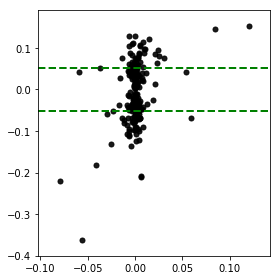

In [10]:
from sklearn.metrics import average_precision_score
from scipy.stats import spearmanr, pearsonr

save_figs = False

blacklist_ids = [
    'chr5_76728085_C_T'
]

snp_pred_df = pd.read_csv("predictions/apa_gtex_data/polyadb_merged_lead_SNPs_deeppasta.csv", sep='\t')

snp_pred_df['cis_snp'] = snp_pred_df['snp_distance'].apply(lambda x: 1. if x < 150 else -1.)

snp_pred_df['snp_pos'] = snp_pred_df['rel_snp_pos'] - 105

snp_pred_df['delta_isoform_logodds'] = snp_pred_df['delta_isoform_logodds_' + tissue_type_map[tissue_type]]

#PDUI
snp_pred_df['mean_PDUI_pred_var'] = 1. - 1. / (1. + (snp_pred_df['mean_PDUI'] / (1. - snp_pred_df['mean_PDUI'])) * np.exp(snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']))
snp_pred_df['effect_size_pred'] = snp_pred_df['mean_PDUI_pred_var'] - snp_pred_df['mean_PDUI']

snp_pred_df['delta_isoform_logodds'] = snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']

snp_pred_df = snp_pred_df.drop(columns=['mean_PDUI_pred_var'])

lead_snp_pred_df = snp_pred_df.copy().reset_index(drop=True)

lead_snp_pred_df['cut_to_snp'] = np.abs(lead_snp_pred_df['snp_pos'] - 100)
lead_snp_pred_df = lead_snp_pred_df.sort_values(by='cut_to_snp', ascending=True).drop_duplicates(subset=['snp_id'], keep='first')

lead_snp_pred_df = lead_snp_pred_df.sort_values(by='snp_id').copy().reset_index(drop=True)

filtered_df = lead_snp_pred_df.query("n_tissues > 1 and snp_pos >= 20 and snp_pos < 126 and pas != -1")# and site_type == '3_most_exon'

filtered_df = filtered_df.loc[~filtered_df['snp_id'].isin(blacklist_ids)]

#Compute classification score
y_labels = np.array(filtered_df['effect_size_median'].apply(lambda x: 0 if x < 0. else 1).values)
y_score = np.array(filtered_df['effect_size_pred'].values)

average_precision = average_precision_score(y_labels, y_score)

print("Direction AP = " + str(round(average_precision, 3)))

q_val = np.quantile(np.abs(filtered_df['effect_size_median'].values), q=0.5)

y_labels = np.array(filtered_df['effect_size_median'].apply(lambda x: 0 if np.abs(x) < q_val else 1).values)
y_score = np.array(filtered_df['effect_size_pred'].values)

average_precision = average_precision_score(y_labels, y_score)

print("Significant AP (qtl = " + str(round(q_val, 3)) + ") = " + str(round(average_precision, 3)))

#Plot predictions
r_val, p_val = spearmanr(filtered_df['effect_size_pred'], filtered_df['effect_size_median'])

print("spearman r = " + str(round(r_val, 3)))
print("p-value = " + str(round(p_val, 50)))

print("n = " + str(len(filtered_df)))

f = plt.figure(figsize=(4, 4))

plt.scatter(filtered_df['effect_size_pred'], filtered_df['effect_size_median'], color='black', s=25, alpha=0.9)

plt.axhline(y=-q_val, linewidth=2, linestyle='--', color='green')
plt.axhline(y=q_val, linewidth=2, linestyle='--', color='green')

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_apaqtl_pred_deeppasta_median_scatter.png", dpi=150, transparent=True)
    plt.savefig("gtex_apaqtl_pred_deeppasta_median_scatter.eps")

plt.show()
